In [1]:
# import libaries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import tqdm
import tensorboardX
import logging
import os
import time
import random
import tifffile

In [2]:
# set random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# set hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 500
# latent_dim = 4
latent_dim = 32
hidden_dim = [32, 64, 128]
in_channels = 4
# num_classes = 4

time_stamp = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

checkpoint_dir = os.path.join('checkpoints', time_stamp)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

log_dir = os.path.join('logs', time_stamp)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.addHandler(logging.FileHandler(os.path.join(log_dir, 'log.txt')))
logger.info('device: {}'.format(device))
logger.info('batch_size: {}'.format(batch_size))
logger.info('learning_rate: {}'.format(learning_rate))
logger.info('num_epochs: {}'.format(num_epochs))
logger.info('latent_dim: {}'.format(latent_dim))
logger.info('hidden_dim: {}'.format(hidden_dim))
logger.info('input_dim: {}'.format(in_channels))
# logger.info('num_classes: {}'.format(num_classes))

writer = tensorboardX.SummaryWriter(log_dir)

# tensorboard --logdir=logs --port=6006


2023-07-14 12:48:53,748 - INFO - device: cuda
2023-07-14 12:48:53,748 - INFO - batch_size: 128
2023-07-14 12:48:53,749 - INFO - learning_rate: 0.001
2023-07-14 12:48:53,749 - INFO - num_epochs: 500
2023-07-14 12:48:53,749 - INFO - latent_dim: 4
2023-07-14 12:48:53,750 - INFO - hidden_dim: [32, 64, 128]
2023-07-14 12:48:53,750 - INFO - input_dim: 4


c:\Users\hx57\AppData\Local\anaconda3\envs\jra\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([4, 32, 32]) torch.float32


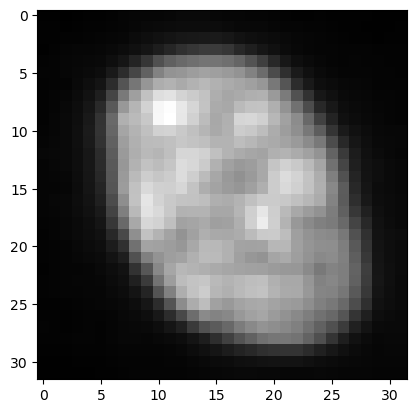

In [5]:
# load data
data_path = os.path.join(os.getcwd(), 'data/single_cell_data/')
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])

class CellDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.data_path = data_path
        self.data = os.listdir(data_path)
        self.data.sort()
        self.data = [os.path.join(data_path, i) for i in self.data]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = tifffile.imread(self.data[idx])
        # print(self.data[idx])
        img = np.transpose(img, (1, 2, 0))
        # print(img.shape)
        min_val = np.min(img)
        max_val = np.max(img)
        normalized_image = (img - min_val) / (max_val - min_val)
        normalized_image = normalized_image.astype(np.float32)
        # img = img / np.max(img)
        # img = img.reshape(1, 64, 64)
        if self.transform:
            img = self.transform(normalized_image)
        return img
    
dataset = CellDataset(data_path, transform=trans)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# test CellDataset
for i in range(1):
    img = dataset[i]
    print(img.shape, img.dtype)
    plt.imshow(img[0], cmap='gray')
    plt.show()


In [6]:
# define VAE model
class VanillaVAE(nn.Module):
    def __init__(self, in_channels, latent_dim, hidden_dims = None, **kwargs):
        super(VanillaVAE, self).__init__()

        self.in_channels = in_channels
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
            # hidden_dims = [32, 64, 128]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= self.in_channels,
                                      kernel_size= 3, padding= 1))

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        # print('encoder: ', result.shape)
        result = torch.flatten(result, start_dim=1)
        # print('encoder: ', result.shape)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return mu, log_var

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        # print('0', z.shape)
        result = self.decoder_input(z)
        # print('1', result.shape)
        result = result.view(-1, 128, 4, 4)
        # print('2', result.shape)
        result = self.decoder(result)
        # print('3', result.shape)
        result = self.final_layer(result)
        # print('4', result.shape)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  self.decode(z), input, mu, log_var

    def loss_function(self, *args, **kwargs):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self, num_samples, current_device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]


In [7]:
# test VAE model
test_hidden_dims = [32, 64, 128]
model = VanillaVAE(in_channels=in_channels, latent_dim=latent_dim, hidden_dims=test_hidden_dims)
model.to(device)
print(model)

# test model
for i, (img) in enumerate(dataloader):
    img = img.to(device)
    print(img.shape)
    out, input, mu, log_var = model(img)
    print(out[0].shape)
    break

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=2048, out_features=4, bias=True)
  (fc_var): Linear(in_features=2048, out_features=4, bias=True)
  (decoder_input): Linear(in_features=4, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): Sequential(
   

In [8]:
# define loss function
def loss_function(recon_x, x, mu, logvar):
    # print(recon_x.shape, x.shape)
    # MSE = F.gaussian_nll_loss(recon_x, x, torch.ones_like(recon_x)*0.1, reduction='sum')
    # print(MSE.shape)
    MSE = torch.mean(torch.sum(F.gaussian_nll_loss(recon_x, x, torch.ones_like(recon_x)*0.1, reduction='none'), dim=(1, 2, 3)), dim=0)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
    # print(MSE.shape, KLD.shape)
    return MSE + KLD

# test loss function
out = torch.randn(128, 4, 32, 32)
input = torch.randn(128, 4, 32, 32)
mu = torch.randn(128, 4)
log_var = torch.randn(128, 4)
loss = loss_function(out, input, mu, log_var)
print(loss.shape)
print(loss)

torch.Size([])
tensor(36178.7109)


In [9]:
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# train model
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for i, data in tqdm.tqdm(enumerate(dataloader)):
        data = data.to(device)
        recon_batch, input, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % (len(dataloader)//5) == 0:
            writer.add_scalar('loss', loss.item(), epoch*len(dataloader)+i)
            logger.info('Epoch: [{}/{}], Step: [{}/{}], Loss: {}'.format(epoch+1, num_epochs, i+1, len(dataloader), loss.item()))
            # print('Epoch: [{}/{}], Step: [{}/{}], Loss: {}'.format(epoch+1, num_epochs, i+1, len(dataloader), loss.item()))

    writer.add_scalar('total_loss', total_loss, epoch)
    logger.info('Epoch: [{}/{}], Total Loss: {}'.format(epoch+1, num_epochs, total_loss))
    # print('Epoch: [{}/{}], Total Loss: {}'.format(epoch+1, num_epochs, total_loss))
    
    # save model
    if (epoch+1) % 10 == 0:
        idx = np.random.randint(0, len(data))
        # print(data.shape, recon_batch.shape)
        writer.add_image('original', data[idx][0].unsqueeze(0), epoch+1)
        writer.add_image('reconstruction', recon_batch[idx][0].unsqueeze(0), epoch+1)
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'VAE_Epoch_{}_Loss_{}.pth'.format(epoch+1, total_loss)))
        logger.info('Save model at epoch {}'.format(epoch+1))
        tifffile.imwrite(os.path.join(log_dir, 'original_{}.tif'.format(epoch+1)), data[idx].view(4, 32, 32).cpu().numpy())
        tifffile.imwrite(os.path.join(log_dir, 'reconstruction_{}.tif'.format(epoch+1)), recon_batch[idx].view(4, 32, 32).cpu().detach().numpy())

# close writer
writer.close()

#close logger
logger.removeHandler(logger.handlers[0])

0it [00:00, ?it/s]2023-07-14 12:48:56,758 - INFO - Epoch: [1/500], Step: [1/591], Loss: 1543.28466796875
117it [00:08, 13.93it/s]2023-07-14 12:49:05,408 - INFO - Epoch: [1/500], Step: [119/591], Loss: -4535.7978515625
235it [00:17, 13.52it/s]2023-07-14 12:49:14,118 - INFO - Epoch: [1/500], Step: [237/591], Loss: -4597.46435546875
353it [00:26, 12.54it/s]2023-07-14 12:49:23,172 - INFO - Epoch: [1/500], Step: [355/591], Loss: -4607.76416015625
471it [00:35, 13.59it/s]2023-07-14 12:49:32,039 - INFO - Epoch: [1/500], Step: [473/591], Loss: -4611.87744140625
589it [00:44, 14.00it/s]2023-07-14 12:49:40,879 - INFO - Epoch: [1/500], Step: [591/591], Loss: -4635.79541015625
591it [00:44, 13.33it/s]
2023-07-14 12:49:40,881 - INFO - Epoch: [1/500], Total Loss: -2693082.3092041016
0it [00:00, ?it/s]2023-07-14 12:49:40,955 - INFO - Epoch: [2/500], Step: [1/591], Loss: -4628.6103515625
118it [00:08, 12.63it/s]2023-07-14 12:49:49,893 - INFO - Epoch: [2/500], Step: [119/591], Loss: -4622.08544921875
2

In [11]:
# # visualize latent space
# model.eval()
# with torch.no_grad():
#     for i, data in tqdm.tqdm(enumerate(dataloader)):
#         data = data.to(device)
#         recon_batch, mu, logvar = model(data)
#         if i == 0:
#             z = mu
#             label = torch.zeros(batch_size)
#         else:
#             z = torch.cat((z, mu), dim=0)
#             label = torch.cat((label, torch.zeros(batch_size)+i), dim=0)
#     z = z.cpu().numpy()
#     label = label.cpu().numpy()

# plt.figure(figsize=(10, 10))
# plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10')
# plt.colorbar()
# plt.savefig(os.path.join(log_dir, 'latent_space.png'))
# plt.show()


In [19]:
# visualize reconstruction
model.eval()
with torch.no_grad():
    for i, data in tqdm.tqdm(enumerate(dataloader)):
        data = data.to(device)
        recon_batch, input, mu, logvar = model(data)
        # if i == 0:
        #     recon = recon_batch
        # else:
        #     recon = torch.cat((recon, recon_batch), dim=0)
    recon_batch = recon_batch.cpu().numpy()
print(recon_batch.shape, data.shape)

0it [00:00, ?it/s]c:\Users\hx57\AppData\Local\anaconda3\envs\jra\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
591it [00:40, 14.65it/s]

(48, 4, 32, 32) torch.Size([48, 4, 32, 32])


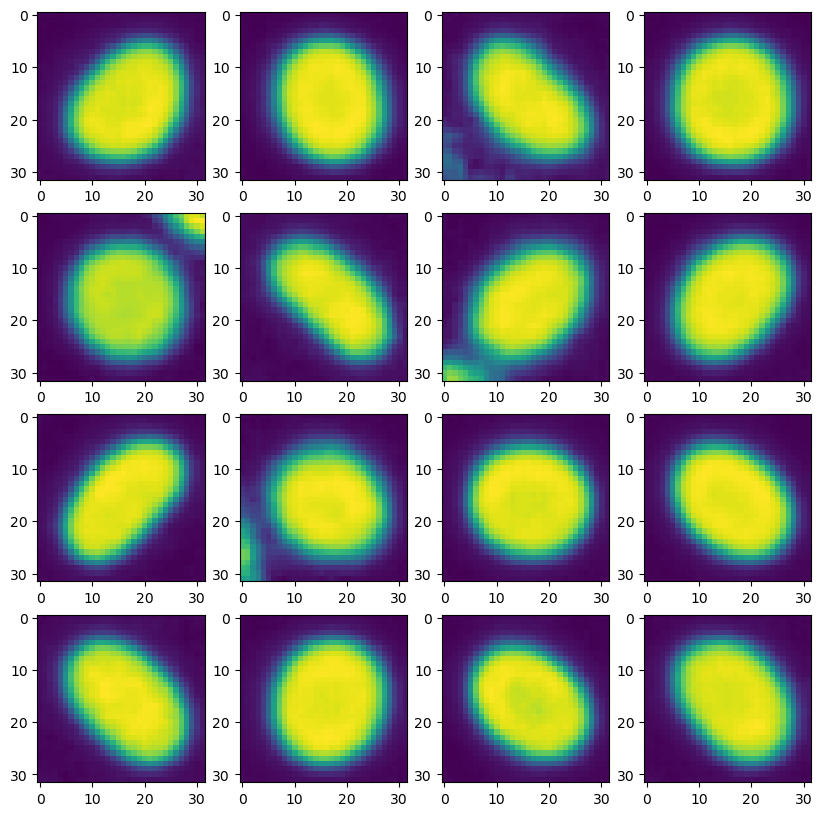

In [21]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(recon_batch[i][0])
plt.savefig(os.path.join(log_dir, 'reconstruction.png'))
plt.show()

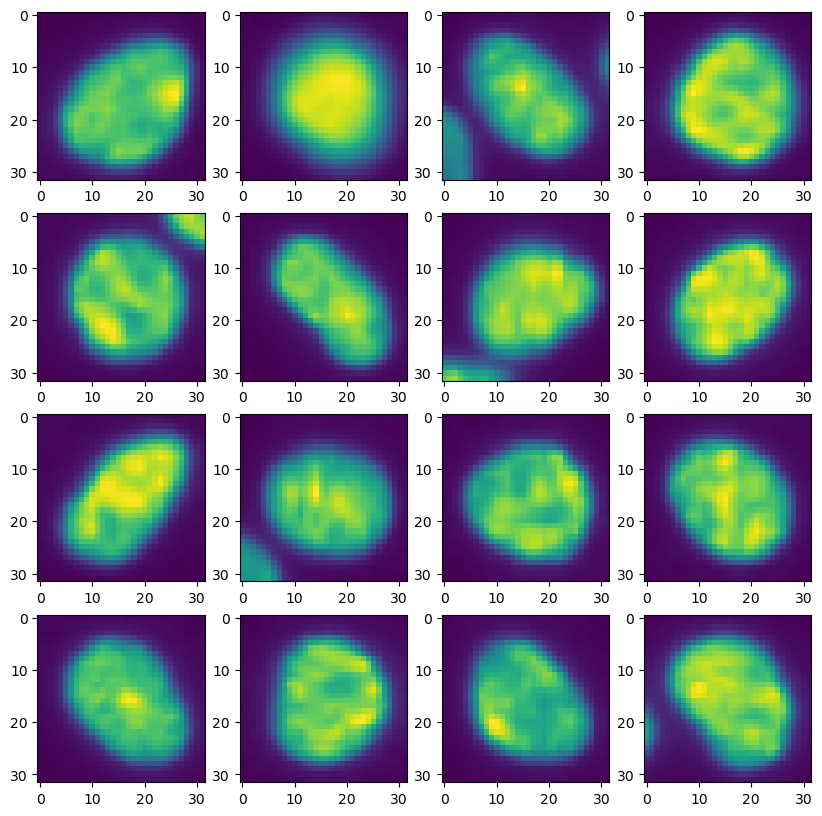

In [22]:
data = data.cpu().numpy()
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(data[i][0])
plt.savefig(os.path.join(log_dir, 'original.png'))
plt.show()